In [ ]:
#importing necessary libraries
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#to ignore all warnings that may appear
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#loading the train and test datasets
df=pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")

test_df = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')


In [ ]:
#checking the datatypes
data_types=df.dtypes
print(data_types)

In [ ]:
#checking for missing values in train and test
missing_values = df.isna().sum()
print(missing_values)

missing_values = test_df.isna().sum()
print(missing_values)

There are no missing values in either of them.

In [ ]:
#setting date as index as it is timeseries data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

from sklearn.preprocessing import StandardScaler
# Initialize StandardScaler
scaler = StandardScaler()


In [ ]:

#date as index for test data also
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)



# Time Series Decomposition

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose


# Performing seasonal decomposition using multiplicative model
result = seasonal_decompose(df['Close'], model='multiplicative', period=12)  
#close is the target column

# Access the decomposed components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Optionally, you can plot the components
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['Close'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


On decomposition of the data, we see that the seasonal component seems to be following a repeated pattern over a period of time. This indicates that there is seasonality in the time series data.
Hence it would be more appropriate to use models like sarima or sarimax ,accounting for the seasonality.

# ACF-PACF Plots

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Plotting ACF for the 'Close' column
plt.figure(figsize=(10, 5))
plot_acf(df['Close'], lags=20)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF) for Close')
plt.show()


From the above graph we can see that p 

In [ ]:
# Plotting PACF for the 'Close' column
plt.figure(figsize=(10, 5))
plot_pacf(df['Close'], lags=20)  # Adjust 'lags' as needed
plt.title('Partial Autocorrelation Function (PACF) for Close')
plt.show()

# ADF Test

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller


t = adfuller(df['Close'])

if t[1] > 0.05:
    print("Time series is not stationary")
else:
    print("Time series is stationary")

print('ADF Statistic:', t[0])
print('p-value:', t[1])
print('Critical Values:', t[4])

On performing the adf test on our data we see that the p value is greater than the significance level of 0.05 which indicates that the data is not stationary.This indicates that the data could be following trends or seasonal patterns. 

In [ ]:
import statsmodels.api as sm

# perform differencing
train_diff = df.Close.diff(1)
train_diff.dropna(inplace=True)
t = sm.tsa.adfuller(train_diff)
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

if t[1] > 0.05:
    print("Time series is not stationary")
else:
    print("Time series is stationary")

print('ADF Statistic:', t[0])
print('p-value:', t[1])
print('Critical Values:', t[4])

We have performed first order differencing , to convert the time series into stationary data.This is because on doing so the data will be more stable and can be used in predictions easily.As just one differencing made it stationary, we conclude that the d value is equal to 1.

# Feature Engineering

In [ ]:
span = 7 # for each week

# Calculating EMA
df['EMA_Open'] = df['Open'].ewm(span=span, adjust=False).mean()
test_df['EMA_Open'] = test_df['Open'].ewm(span=span, adjust=False).mean()

df['EMA_Open'].fillna(0, inplace=True)
test_df['EMA_Open'].fillna(0, inplace=True)

# Calculate EMA
df['EMA_Open_rf'] = df['Open'].ewm(span=50, adjust=False).mean()
test_df['EMA_Open_rf'] = test_df['Open'].ewm(span=50, adjust=False).mean()

df['EMA_Open_rf'].fillna(0, inplace=True)
test_df['EMA_Open_rf'].fillna(0, inplace=True)

# macd 
df['MACD'] = df['EMA_Open'] - df['EMA_Open_rf']
test_df['MACD'] = test_df['EMA_Open'] - test_df['EMA_Open_rf']


# Initializing StandardScaler
scaler = StandardScaler()

df['SMA_13'] = df['Open'].rolling(window=7).mean()
test_df['SMA_13'] = test_df['Open'].rolling(window=7).mean()

# do back fill for sma_13
df['SMA_13'].fillna(method='bfill', inplace=True)
test_df['SMA_13'].fillna(method='bfill', inplace=True)


# lag for open 
df['lag_1'] = df['Open'].shift(1)
test_df['lag_1'] = test_df['Open'].shift(1)

df['lag_1'].fillna(method='bfill', inplace=True)

test_df['lag_1'].fillna(method='bfill', inplace=True)

df['lag_2'] = df['Open'].shift(2)
test_df['lag_2'] = test_df['Open'].shift(2)

df['lag_2'].fillna(method='bfill', inplace=True)

test_df['lag_2'].fillna(method='bfill', inplace=True)

df['lag_3'] = df['Open'].shift(3)
test_df['lag_3'] = test_df['Open'].shift(3)

df['lag_3'].fillna(method='bfill', inplace=True)

test_df['lag_3'].fillna(method='bfill', inplace=True)


In [ ]:

import seaborn as sns

# Dropping the categorical column for correlation 
correlation_df = df.drop(columns=['Strategy'])


correlation_matrix = correlation_df.corr()


plt.figure(figsize=(10, 8)) 

# plotting a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix')
plt.show()



From the above heatmap we can see that open and close are strongly correlated.As a result any features defined from open will also be strongly correlated with close, which will help in close price prediction.Volume on the other hand is negatively correlated with both opne and close price and hence might not be a good factor in close price prediction.

In [ ]:
df.head()

In [ ]:
# Defining the split ratio (75-25 split)
split_ratio = 0.75

# Calculate the split index based on the ratio

split_index = int(len(df) * split_ratio)

# Split the data into training and validation sets
train_data = df.iloc[:split_index]
val_data = df.iloc[split_index:]

We have not used train-test split as it is time series data.Doing so will ruin the temporal sequence of the data.

In [ ]:
# Create a time series plot between training and validation set
plt.figure(figsize=(12, 6))

plt.plot(train_data.index, train_data['Close'], label='Training Data')
plt.plot(val_data.index, val_data['Close'], label='Validation Data')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# plot df close and open 
df[['Close', 'Open']].plot(figsize=(12, 6))


In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(28, 10))

# Plot the stock price and strategy signals on the primary y-axis
ax1.plot(df['Close'], label='Actual Price', color='blue')

ax1.plot(df['Close'].where(df['Strategy'] == 'Buy'), marker='^', markersize=8, color='green', label='Buy Signal', linestyle='', alpha=0.6)
ax1.plot(df['Close'].where(df['Strategy'] == 'Sell'), marker='v', markersize=8, color='red', label='Sell Signal', linestyle='', alpha=0.6)
ax1.plot(df['Close'].where(df['Strategy'] == 'Hold'), marker='o', markersize=8, color='yellow', label='Hold Signal', linestyle='', alpha=0.6)
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color='blue')
ax1.legend(loc='upper left')

# Create a secondary y-axis for volume
ax2 = ax1.twinx()
ax2.fill_between(df.index, 0, df['Volume'], color='gray', alpha=0.4, label='Volume')
ax2.set_ylabel('Volume', color='gray')
# ax2.legend(loc='upper right')

plt.title('Stock Price and Strategy Recommendations')
plt.show()

Here we plot a graph using close price, that gives us insight into the distribution of buy,sell and hold.We can see that most of the buys are at the minima, while most of the sells are at the maxima . And the holds are scattered up and down the slopes of the minimas and maximas.

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# print correlation of close with other variables except for strategy 

print("lag_1",df['Close'].corr(df['lag_1']))
print("MACD",df['Close'].corr(df['MACD']))
print("EMA_Open_rf",df['Close'].corr(df['EMA_Open_rf']))
print("EMA_Open",df['Close'].corr(df['EMA_Open']))
print("Volume",df['Close'].corr(df['Volume']))
print("Open",df['Close'].corr(df['Open']))
print('SMA_13',df['Close'].corr(df['SMA_13']))
print('lag_2',df['Close'].corr(df['lag_2']))
print('lag_3',df['Close'].corr(df['lag_3']))

In [ ]:
df['SMA_13']

# SARIMAX for Close price Forecast

In [ ]:
# Fit SARIMAX model with 'Volume' as exogenous variable
model = SARIMAX(train_data['Close'], exog=train_data[['Open','EMA_Open', 'MACD', 'SMA_13', 'lag_1', 'lag_2', 'lag_3' , ]], order=(1,1,1), seasonal_order=(1,1,1,7))
model = model.fit()

For the SARIMAX we have used most of the strongly positively correlated features for the close price prediction. The order has been decided from looking at the ACF and PACF plots, s is 7 as we are considering a seasonal pattern that repeats over seven days.

In [ ]:
forecast = model.get_forecast(steps=75, exog=val_data[['Open','EMA_Open', 'MACD', 'SMA_13',  'lag_1', 'lag_2', 'lag_3' ]])
forecast_values = forecast.predicted_mean

# print(forecast_values)

val_data['P_Close'] = forecast_values

In [ ]:
val_data[['Close', 'P_Close']].plot(figsize=(12, 6))

In [ ]:
val_data[[ 'P_Close', 'Open']].plot(figsize=(12, 6))

In [ ]:
import numpy as np

In [ ]:
smape = np.mean(np.abs(val_data['P_Close'] - val_data['Close']) / (np.abs(val_data['P_Close']) + np.abs(val_data['Close'])))
print('SMAPE:', smape)

In [ ]:
rmse = np.sqrt(np.mean((val_data['P_Close'] - val_data['Close'])**2))
print('RMSE:', rmse)

## Is this a case of overfitting?? 
It might look like it is because of very low smape of 0.008 but when we look at the pattern followed by Close and Open in train data and predicted Close and Open in test data, we can visualize similarities both the graphs have

### different sarimax for test

In [ ]:
# Fit SARIMAX model with 'Volume' as exogenous variable
model = SARIMAX(df['Close'], exog=df[['Open','EMA_Open', 'MACD', 'SMA_13','lag_1', 'lag_2', 'lag_3' ]], order=(1,1,1), seasonal_order=(1,1,1,7))
model = model.fit()

In [ ]:
forecast = model.get_forecast(steps=100, exog=test_df[['Open','EMA_Open', 'MACD', 'SMA_13','lag_1', 'lag_2', 'lag_3' ]])
forecast_values = forecast.predicted_mean

# print(forecast_values)

test_df['Close'] = forecast_values

In [ ]:
test_df[['Open','Close']].plot(figsize=(12, 6))

In [ ]:
# correlation of open and close in test data   
print("Open",test_df['Close'].corr(test_df['Open']))

In [ ]:
# ema of close in test data
df['EMA_Close'] = df['Close'].ewm(span=span, adjust=False).mean()
test_df['EMA_Close'] = test_df['Close'].ewm(span=span, adjust=False).mean()

# RANDOM FOREST for Classification

In [ ]:
# Define the mapping
label_mapping = {'Sell': 0, 'Hold': 1, 'Buy': 2}

# Mapping the labels to numeric values and create a new column 'NumericLabel'
df['NumericLabel'] = df['Strategy'].map(label_mapping)

In [ ]:
# random forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Separate features and labels
X = (df[[  'Close','Open','EMA_Open', 'MACD', 'SMA_13', ]])
y = df['NumericLabel']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initializing the model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=14, random_state=62)

# Training the model
rf_model.fit(X_train, y_train)

# Predicting on the test data
y_pred = rf_model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

prediction = rf_model.predict((test_df[[ 'Close','Open','EMA_Open', 'MACD', 'SMA_13',]]))
print(prediction)

strategy = []
for i in prediction:
    if i == 0:
        strategy.append('Sell')
    elif i == 1:
        strategy.append('Hold')
    else:
        strategy.append('Buy')

test_df['Strategy'] = strategy


In [ ]:
# rmse of above model
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

In [ ]:

fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot the stock price and strategy signals on the primary y-axis
ax1.plot(test_df['Close'], label='Actual Price', color='blue')
# ax1.plot(test_df['Open'], label = 'Open', color = 'green')
ax1.plot(test_df['Close'].where(test_df['Strategy'] == 'Buy'), marker='^', markersize=8, color='green', label='Buy Signal', linestyle='', alpha=0.6)
ax1.plot(test_df['Close'].where(test_df['Strategy'] == 'Sell'), marker='v', markersize=8, color='red', label='Sell Signal', linestyle='', alpha=0.6)
ax1.plot(test_df['Close'].where(test_df['Strategy'] == 'Hold'), marker='o', markersize=8, color='yellow', label='Hold Signal', linestyle='', alpha=0.6)
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color='blue')
ax1.legend(loc='upper left')

# Create a secondary y-axis for volume
ax2 = ax1.twinx()
ax2.fill_between(test_df.index, 0, test_df['Volume'], color='gray', alpha=0.4, label='Volume')
ax2.set_ylabel('Volume', color='gray')
# ax2.legend(loc='upper right')

plt.title('Stock Price and Strategy Recommendations')
plt.show()

In [ ]:
# Reset the index to access 'Date' as a column
test_data = test_df.reset_index()

# Add an 'id' column starting from 0
test_data['id'] = test_data.index

final_df = test_data[['id','Date', 'Close', 'Strategy']]
final_df.head()

In [ ]:
final_df.to_csv('submission.csv', index = False)

### SCORE 19.4

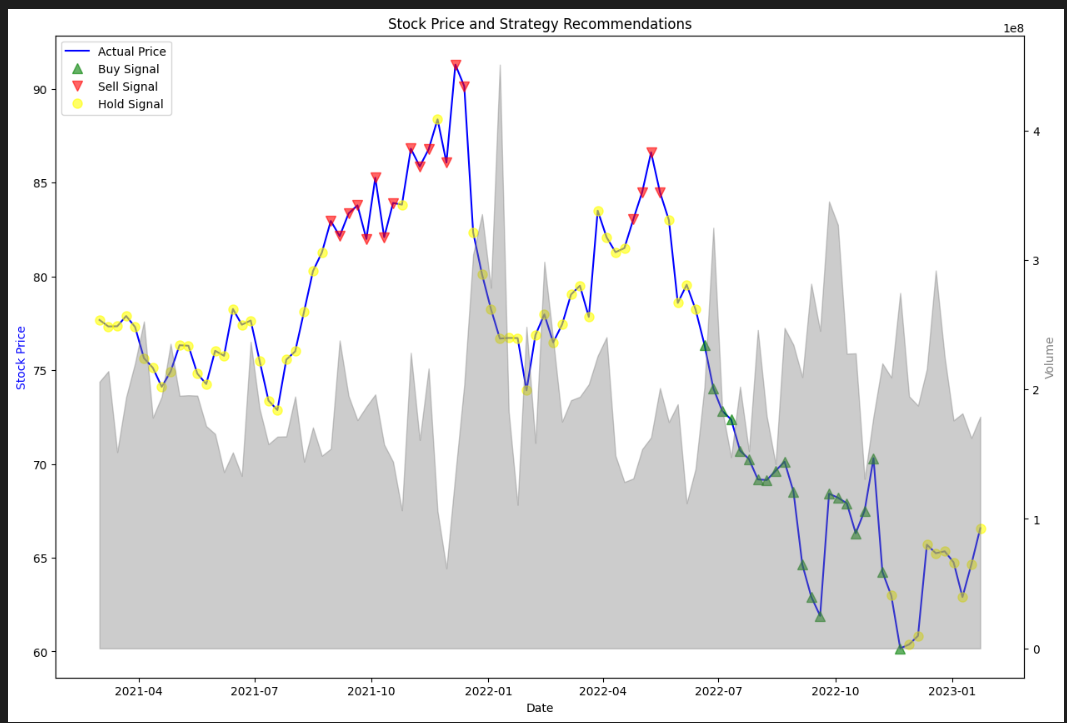

SARIMAX = 'Open','EMA_Open', 'MACD', 'SMA_13',  'lag_1', 'lag_2', 'lag_3'  span = 7/50 win = 7

smape = 0.008 rmse = 1.76

RF = 'Close','Open','EMA_Open', 'MACD', 'SMA_13',

acc = 77% rmse = 0.47

no normalization anywhere 

### SCORE = 22.56 NO NORM
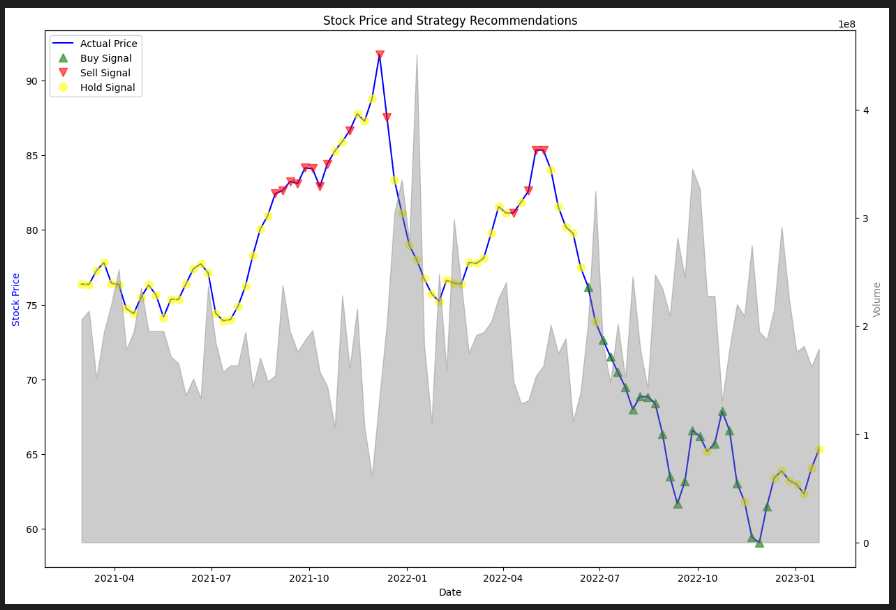
sarimax = 'Open','EMA_Open','SMA_13', 'lag_1', 'MACD',  smape = 0.0103

RF = 'Close','Open','EMA_Open', 'SMA_13','lag_1', 'MACD', 'lag_1' acc = 74.666%
